In [1]:
import backtrader as bt
from backtrader import Indicator
import pyfolio as pf
import alphalens
from alphalens import performance as perf
from alphalens import plotting, utils
import ta
import pandas as pd
import numpy as np
import itertools
from datetime import datetime
import pandas_datareader.data as web
import yfinance as yf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [554]:
prices = pickle.load(open('Prices.pkl', 'rb'))

In [555]:
symbols = ['SCP.JO',
            'NGPLT.JO',
            'LBH.JO',
            'NTC.JO',
            'PPC.JO',
            'INP.JO',
            'PAN.JO',
            'CML.JO',
            'SHP.JO',
            'IPL.JO',
            'NGPLT.JO',
            'AGL.JO',
            'SCP.JO',
            'VKE.JO',
            'LEW.JO',
            'IPF.JO',
            'INP.JO',
            'REM.JO',
            'HCI.JO',
            'NGPLD.JO',
#             'GLPROP.JO'
          ]

In [556]:
start = '2015-01-01'
end = '2017-12-31'
train_prices = {}
for symbol, data in prices.items():
    if symbol in symbols:
        data = data.loc[start:end]
        train_prices[symbol] = data

In [557]:
def getIndicator(trainPrices,
                 indicator,
                 filter = 'QTradeable',
                 trailing_volume_n = 200, 
                 *args, **kwargs):


    factor_df = pd.DataFrame()
    for i, (symbol, data) in enumerate(trainPrices.items()):
        if len(data) > trailing_volume_n:
            data = data.copy()

            open = data['open']
            high = data['high']
            low = data['low']
            close = data['close']
            volume = data['volume']
#             adj_close = data['adj_close']


            factor = indicator(
                open = open,
                high = high,
                low = low,
                close = close,
                volume = volume,
                *args, **kwargs
            )
            factor_name = factor.name

            out = pd.DataFrame(factor)
            out['symbol'] = symbol
            out.index.name = 'date'
            out = out.reset_index().set_index(['date', 'symbol'])

            if filter == 'QTradeable':

                def getTrailingVolume(
                    close, volume, symbol, n = trailing_volume_n):

                    volume = data['volume']
                    dollar_volume = volume.mul(close)

                    trailing_dollar_volume = dollar_volume.rolling(
                            window = n).median()
                    trailing_dollar_volume.name = 'trailing_dollar_volume'

                    trailing_dollar_volume = pd.DataFrame(trailing_dollar_volume)

                    trailing_dollar_volume['symbol'] = symbol

                    trailing_dollar_volume = trailing_dollar_volume.reset_index().set_index(['date', 'symbol'])

                    return trailing_dollar_volume

                def getPricing(close, symbol):
                    prices = pd.DataFrame(close)
                    prices['symbol'] = symbol
                    prices = prices.reset_index().set_index(['date', 'symbol'])

                    return prices

                # volume filter
                trailing_dollar_volume = getTrailingVolume(close, volume, symbol)

                # price filter
                prices = getPricing(close, symbol)

                out = pd.concat(
                    [out, trailing_dollar_volume, prices], 
                    axis = 1)

                QTradeableStocks_median_dollar_volume = 2500000
                exchange_rate = 16.56
                minimum_dollar_volume = QTradeableStocks_median_dollar_volume * exchange_rate
    
                QTradeableStocks_minimun_price = 5
                minimum_price = QTradeableStocks_minimun_price * exchange_rate

                volume_mask = out['trailing_dollar_volume'] > minimum_dollar_volume
                price_mask = out['close'] > minimum_price

                out = out[volume_mask & price_mask][[factor_name]]

            factor_df = pd.concat([factor_df, out])#.unstack().asfreq('C').stack()
    return factor_df

In [558]:
#bbands, percentB
def percentB(open = None, high = None, low = None, close = None, volume = None,
             n = 20, ndev = 2):
    bbands = ta.volatility.BollingerBands(close, n = n, ndev = ndev)
    upper = bbands.bollinger_hband()
    lower = bbands.bollinger_lband()

    perc_b = ((close - lower)/(upper - lower)) * -1
    perc_b.name = 'perc_b'
    perc_b
    return perc_b

In [559]:
def getPrices(trainPrices, symbols):
    prices_data = pd.DataFrame()
    for symbol, data in trainPrices.items():
        if symbol in symbols:
            out = data['close']
            out.name = symbol
            prices_data = pd.concat([prices_data, out], axis = 1)
    prices_data.index = pd.to_datetime(prices_data.index)
    return prices_data#.asfreq('C')

In [560]:
bbands_data = getIndicator(train_prices, percentB)
bbands_data

,,perc_b
date,symbol,
2015-10-07,AGL.JO,-0.528870
2015-10-08,AGL.JO,-0.548174
2015-10-09,AGL.JO,-0.725114
2015-10-12,AGL.JO,-0.602271
2015-10-13,AGL.JO,-0.589727
...,...,...
2017-12-25,VKE.JO,-0.843483
2017-12-26,VKE.JO,-0.813039
2017-12-27,VKE.JO,-0.812873


In [561]:
prices_data = getPrices(train_prices, symbols = bbands_data.index.levels[1])

In [562]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(
    factor = bbands_data,
    prices = prices_data,
    quantiles = 3,
    periods = [1, 2, 5]
)
factor_data

Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        2D        5D    factor  factor_quantile
date       asset                                                          
2015-10-07 AGL.JO  0.001819  0.070925  0.012294 -0.528870                3
           CML.JO -0.011321  0.009509  0.068528 -0.170778                3
           HCI.JO  0.000000  0.003546 -0.001773 -0.723925                2
           INP.JO -0.006643 -0.000898 -0.020738 -0.774252                2
           IPF.JO -0.015878 -0.025398 -0.028574 -0.652200                2
...                     ...       ...       ...       ...              ...
2017-12-22 PAN.JO  0.000000  0.000000  0.008475 -0.104220                3
           PPC.JO  0.000000  0.000000  0.008759 -0.638500                2
           REM.JO  0.000000  0.000000  0.032057 -0.814349                1
           SHP.JO  0.000000  0.000000  0.084352 -0.038869                3
           VKE.JO  0.000000  0.000000  0.006763 -0.879014                1

[9587 rows x 5 columns]

In [563]:
def plotFactorQuantileBars(
    factor_data, demeaned = True, by_group = False, group_adjust = False):
    
    mean_quant_ret, std_quantile = perf.mean_return_by_quantile(
        factor_data,
        demeaned = demeaned,
        by_group = by_group,
        group_adjust = group_adjust)

    mean_quant_rateret = mean_quant_ret.apply(
        utils.rate_of_return, 
        axis = 0,
        base_period = mean_quant_ret.columns[0])
    
    plotting.plot_quantile_returns_bar(mean_quant_rateret,
                                   by_group = by_group,
                                   ylim_percentiles = None)
    plt.show()

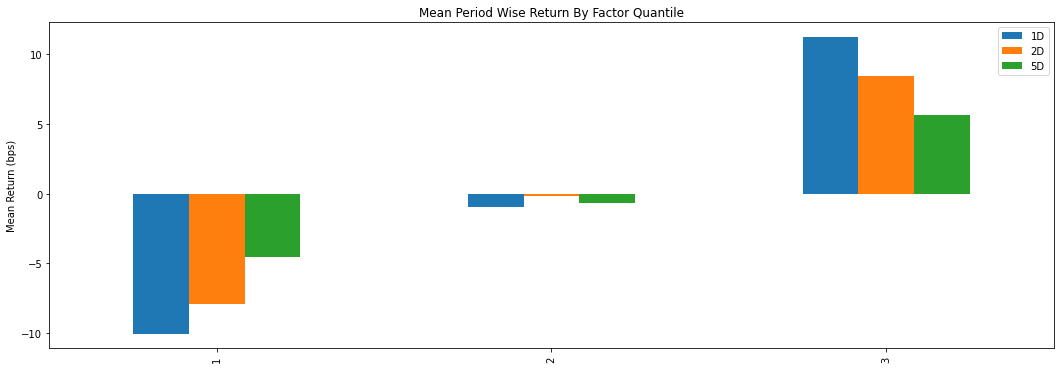

In [564]:
plotFactorQuantileBars(factor_data, by_group = False, group_adjust = False)

In [565]:
def plotCumulativeReturns(factor_data, p = '1D', demeaned = True, group_adjust = False):
    factor_returns = perf.factor_returns(
        factor_data, 
        demeaned = demeaned, 
        group_adjust = group_adjust)

    fig = plt.figure(figsize = (16, 8))
    p = '1D'
    title =         'Factor weighted LONG/SHORT portfolio cumulative returns'
    plotting.plot_cumulative_returns(
        factor_returns[p],
        period = p)
    plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:694: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


<Figure size 1152x576 with 0 Axes>

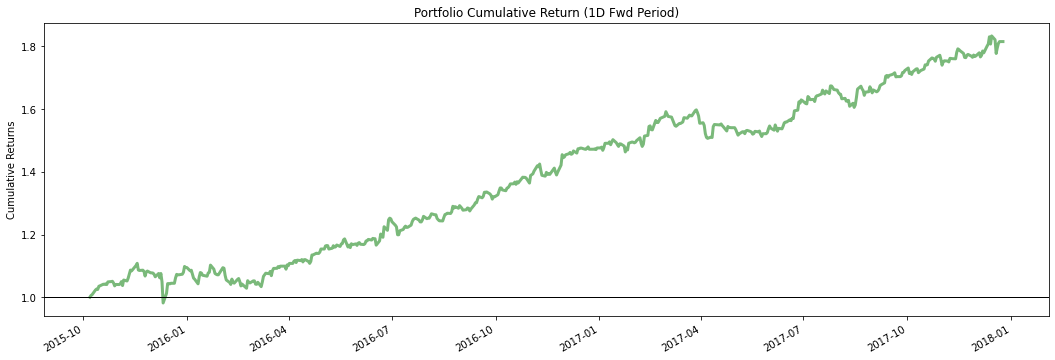

In [566]:
plotCumulativeReturns(factor_data)

In [567]:
import mlfinlab as ml

In [646]:
def getLabels(datas,
              lookback = 20,
              num_days_ahead = 5,
              pt_sl = [1, 1],
              min_ret = 0.005):
    
    output = {}
    for symbol, data in datas.items():
        
        try:
            close = data['close']

            if len(close) > lookback: 

                daily_vol = ml.util.get_daily_vol(
                                close, 
                                lookback = lookback)

                if daily_vol.nunique() != 1:

                    cusum_events = ml.filters.cusum_filter(
                                        close,
                                        threshold = daily_vol)

                    data = data.reset_index()
                    data['event'] = np.where(data['Date'].isin(cusum_events), 1, 0)
                    data.set_index('Date', inplace = True)

                    vertical_barriers = ml.labeling.add_vertical_barrier(
                                            t_events = cusum_events,
                                            close = close,
                                            num_days = num_days_ahead)

                    data['vertical_barriers'] = vertical_barriers

                    triple_barrier_events = ml.labeling.get_events(
                                    close = close,
                                    t_events = cusum_events,
                                    pt_sl = pt_sl,
                                    target = daily_vol,
                                    min_ret = min_ret,
                                    vertical_barrier_times = vertical_barriers,
                                    num_threads = 1,
                                    verbose = False)

                    data = pd.concat(
                        [data, triple_barrier_events], 
                        axis = 1).drop('trgt', axis = 1)

                    labels = ml.labeling.get_bins(
                        triple_barrier_events, close)

                    data = pd.concat([data, labels], axis = 1)
                    data.index.name = 'date'

                    data['profit_taking'] = data['pt'].mul(data['trgt'])
                    data['stop_loss'] = data['sl'].mul(data['trgt']).mul(-1)

                    data.reset_index(inplace = True)
                    data['holding_period'] = pd.to_datetime(data['t1']).sub(pd.to_datetime(data['date']))                        .map(lambda x: x.days)
                    data.drop(['trgt', 'pt', 'sl'], axis = 1, inplace = True)
                    data.set_index('date', inplace = True)

                    data.rename(columns = 
                                {'vertical_barriers':'max_holding_period', 
                                 'ret':'expected_return', 
                                 'bin':'label'
                                }, inplace = True)     
                    output[symbol] = data#[data['event'] == 1]
        except Exception as e:
            print(f"{symbol}: {e}")
    return output

In [647]:
cusumprices = getLabels(train_prices)

In [603]:
data = cusumprices['VKE.JO']
data.iloc[49:]

,high,low,open,close,volume,adj_close,event,max_holding_period,t1,expected_return,label,profit_taking,stop_loss,holding_period
date,,,,,,,,,,,,,,
2015-08-04,1855.0,1808.0,1809.0,1836.0,564289.0,1836.0,1,2015-08-10,2015-08-10,-0.003268,0.0,0.012127,-0.012127,6.0
2015-08-12,1860.0,1820.0,1850.0,1827.0,912342.0,1827.0,1,2015-08-17,2015-08-17,-0.002737,0.0,0.011717,-0.011717,5.0
2015-08-14,1827.0,1810.0,1820.0,1813.0,152075.0,1813.0,1,2015-08-19,2015-08-19,0.003861,0.0,0.011464,-0.011464,5.0
2015-08-21,1817.0,1800.0,1803.0,1803.0,365122.0,1803.0,1,2015-08-26,2015-08-24,-0.026622,-1.0,0.009705,-0.009705,3.0
2015-08-24,1803.0,1746.0,1803.0,1755.0,590667.0,1755.0,1,2015-08-31,2015-08-26,0.029060,1.0,0.012239,-0.012239,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-11,2023.0,1930.0,1950.0,2000.0,765164.0,2000.0,1,2017-12-18,2017-12-13,-0.030000,-1.0,0.020891,-0.020891,2.0
2017-12-13,1990.0,1921.0,1990.0,1940.0,739099.0,1940.0,1,2017-12-18,2017-12-15,0.028351,1.0,0.022475,-0.022475,2.0
2017-12-15,1995.0,1894.0,1958.0,1995.0,5486299.0,1995.0,1,2017-12-20,2017-12-18,0.030075,1.0,0.023180,-0.023180,3.0


In [571]:
trailing_volume_window = 50

In [596]:
bbands_data = getIndicator(
    cusumprices, 
    percentB, 
    trailing_volume_n = trailing_volume_window, 
    n = 12, ndev = 2)
bbands_data = bbands_data.unstack().asfreq('C').stack()
bbands_data

perc_b
date       symbol            
2015-07-06 NGPLT.JO -0.246961
2015-07-07 AGL.JO    0.095259
           NGPLT.JO -0.166311
2015-07-13 AGL.JO   -0.160789
           INP.JO   -1.056783
...                       ...
2017-12-28 PPC.JO   -0.764625
2017-12-29 IPF.JO   -1.044303
           IPL.JO   -0.962536
           NTC.JO   -0.825862
           REM.JO   -0.912237

[3390 rows x 1 columns]

In [598]:
out = bbands_data.reset_index()
out[out['symbol'] == 'VKE.JO'].sort_values('date')

,date,symbol,perc_b
57,2015-08-04,VKE.JO,-0.759086
86,2015-08-12,VKE.JO,-0.653990
94,2015-08-14,VKE.JO,-0.516663
126,2015-08-21,VKE.JO,-0.410757
137,2015-08-24,VKE.JO,0.047155
...,...,...,...
3328,2017-12-11,VKE.JO,-0.748353
3338,2017-12-13,VKE.JO,-0.318650
3351,2017-12-15,VKE.JO,-0.680183
3360,2017-12-18,VKE.JO,-0.972357


In [573]:
prices_data = getPrices(cusumprices, bbands_data.index.levels[1])
prices_data = prices_data.asfreq('C')

In [574]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(
    factor = bbands_data,
    prices = prices_data,
    quantiles = 3,
    periods = [1, 2, 5]
)
factor_data

Dropped 1.1% entries from factor data: 0.3% in forward returns computation and 0.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        2D        5D    factor  factor_quantile
date       asset                                                       
2015-07-07 AGL.JO    0.0  0.000000  0.045725  0.095259              3.0
           NGPLT.JO  0.0  0.000000 -0.015925 -0.166311              1.0
2015-07-13 AGL.JO    0.0  0.000000  0.019762 -0.160789              3.0
           INP.JO    0.0  0.004341  0.004341 -1.056783              1.0
           LBH.JO    0.0  0.000000  0.000000 -1.037237              2.0
...                  ...       ...       ...       ...              ...
2017-12-21 SHP.JO    0.0  0.000000  0.044288 -0.087366              3.0
           VKE.JO    0.0  0.000000  0.000000 -0.959443              1.0
2017-12-22 INP.JO    0.0  0.000000  0.000000 -0.361787              3.0
           IPF.JO    0.0  0.000000  0.058371 -0.471948              2.0
           LEW.JO    0.0  0.000000  0.000000 -0.592716              1.0

[3354 rows x 5 columns]

In [575]:
def getVolumeOsc(open = None, high = None, low = None, close = None, volume = None,
                periods = 5):
    vol_sma = ta.trend.ema(volume, periods = periods)
    vol_sma.name = 'volume_oscillator20'
    return vol_sma

In [576]:
volume_osc_data = getIndicator(
    cusumprices, 
    getVolumeOsc, 
    trailing_volume_n = trailing_volume_window)
volume_osc_data = volume_osc_data.unstack().asfreq('C').stack()

In [577]:
def createGroupingFactor(factor_data, 
                         group_data, 
                         prices_data, 
                         num_groupes = 3):
    
    group_factor_data = alphalens    .utils.get_clean_factor_and_forward_returns(
        factor = group_data,
        prices = prices_data,
        quantiles = num_groupes,
        periods = [1]
    )
#     volume_factor_data

    qroup_quantiles = group_factor_data['factor_quantile']
    qroup_quantiles.name = 'group'
    factor_data_w_group = pd.concat(
        [factor_data, qroup_quantiles], 
        axis = 1).dropna()
    return factor_data_w_group

In [578]:
factor_data = createGroupingFactor(
    factor_data, 
    group_data = volume_osc_data, 
    prices_data = prices_data, 
    num_groupes = 3)
factor_data

Dropped 0.9% entries from factor data: 0.1% in forward returns computation and 0.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        2D        5D    factor  factor_quantile  group
date       asset                                                              
2015-07-07 AGL.JO    0.0  0.000000  0.045725  0.095259              3.0    3.0
           NGPLT.JO  0.0  0.000000 -0.015925 -0.166311              1.0    1.0
2015-07-13 AGL.JO    0.0  0.000000  0.019762 -0.160789              3.0    3.0
           INP.JO    0.0  0.004341  0.004341 -1.056783              1.0    2.0
           LBH.JO    0.0  0.000000  0.000000 -1.037237              2.0    1.0
...                  ...       ...       ...       ...              ...    ...
2017-12-21 SHP.JO    0.0  0.000000  0.044288 -0.087366              3.0    3.0
           VKE.JO    0.0  0.000000  0.000000 -0.959443              1.0    1.0
2017-12-22 INP.JO    0.0  0.000000  0.000000 -0.361787              3.0    3.0
           IPF.JO    0.0  0.000000  0.058371 -0.471948              2.0    1.0
           LEW.JO    0.0  0.000000  0.000000 -0.592716              1.0    2.0

[3354 rows x 6 columns]

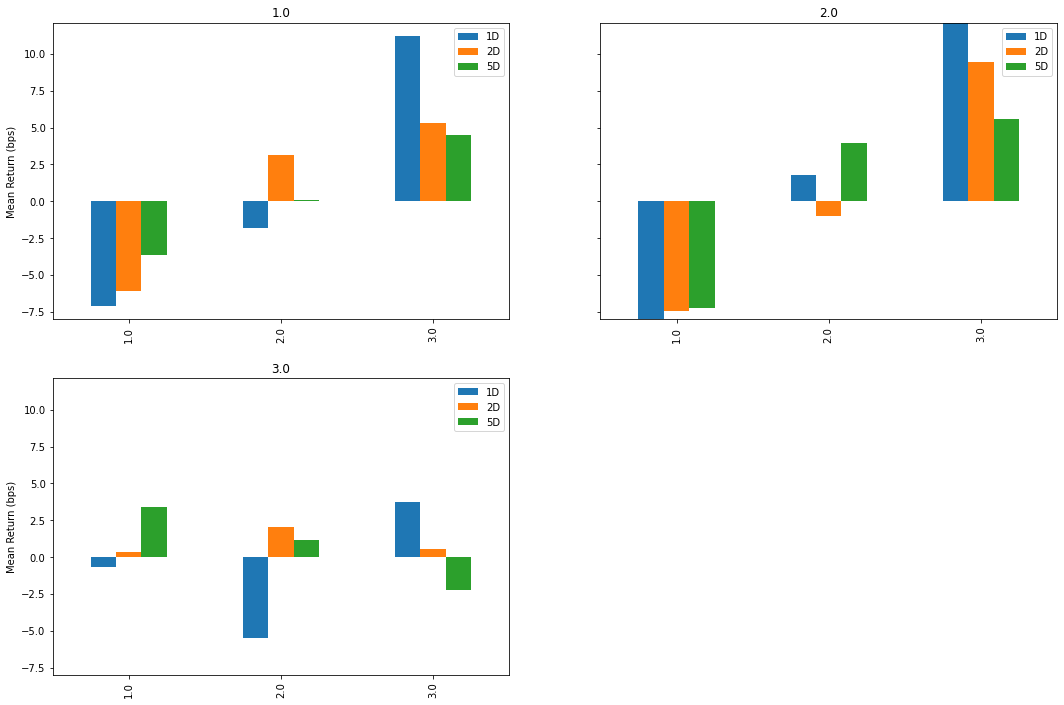

In [593]:
plotFactorQuantileBars(factor_data, by_group = True, group_adjust = True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


<Figure size 1152x576 with 0 Axes>

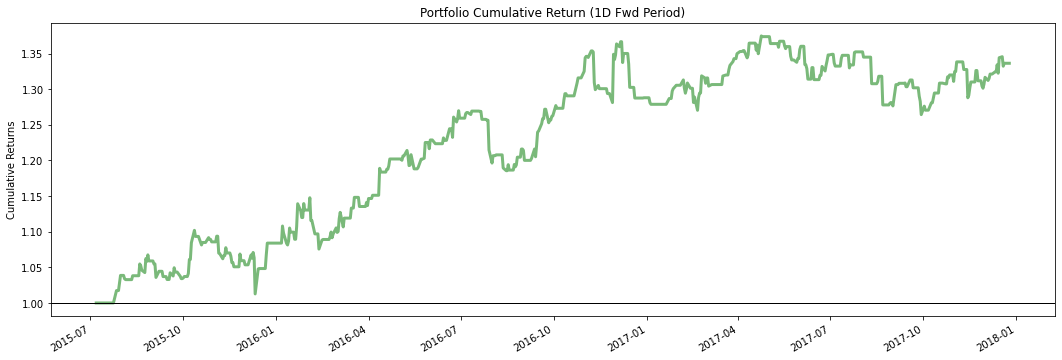

In [594]:
plotCumulativeReturns(factor_data, group_adjust=True)

In [608]:
out = factor_data.reset_index()
out = out[out['asset'] == 'AGL.JO']
out[out['date'].isin(pd.date_range('2015-08-04', '2015-08-31'))]

,date,asset,1D,2D,5D,factor,factor_quantile,group
53,2015-08-05,AGL.JO,0.000000,0.000000,0.000000,-0.270076,2.0,3.0
84,2015-08-14,AGL.JO,0.000000,0.000000,-0.004363,-0.180987,2.0,3.0
97,2015-08-19,AGL.JO,0.036257,0.036257,-0.045408,-0.076978,3.0,3.0
105,2015-08-20,AGL.JO,0.000000,-0.078808,-0.025694,-0.273392,3.0,3.0
122,2015-08-24,AGL.JO,0.000000,0.000000,0.057658,-0.040602,2.0,3.0
150,2015-08-27,AGL.JO,0.000000,0.000000,0.030460,-0.292253,2.0,3.0


In [732]:
target = pd.DataFrame()
for symbol, data in cusumprices.items():
    data = data.copy()
    data['expected_return'] = np.where(data['expected_return'].isna(), 0, data['expected_return'])
    data['holding_period'] = np.where(data['holding_period'] > 5, 5, data['holding_period'])
    data['holding_period'] = np.where(data['holding_period'].isna(), 0, data['holding_period'])
    data['label'] = np.where(data['label'].isna(), 0, data['label'])
    label = data['label']
    events = data['event']
    vv = data[['expected_return', 'holding_period']].copy()
    vv = pd.pivot(vv.reset_index(), index = 'date', columns = 'holding_period', values = 'expected_return')
    vv = pd.DataFrame(np.where(vv.isna(), 0, vv), index = vv.index, columns = vv.columns)
    out = pd.concat([vv, events, label], axis = 1)
    out['asset'] = symbol
    out = out.reset_index().set_index(['date', 'asset'])
    target = pd.concat([target, out])

In [733]:
target

,,0.0,1.0,2.0,3.0,4.0,5.0,event,label
date,asset,,,,,,,,
2015-01-01,AGL.JO,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0
2015-01-02,AGL.JO,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0
2015-01-05,AGL.JO,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0
2015-01-06,AGL.JO,0.0,0.0,0.0,-0.018249,0.0,0.0,1,-1.0
2015-01-07,AGL.JO,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...
2017-12-25,VKE.JO,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0
2017-12-26,VKE.JO,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0
2017-12-27,VKE.JO,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.0


[Text(0.5, 0, ' ')]

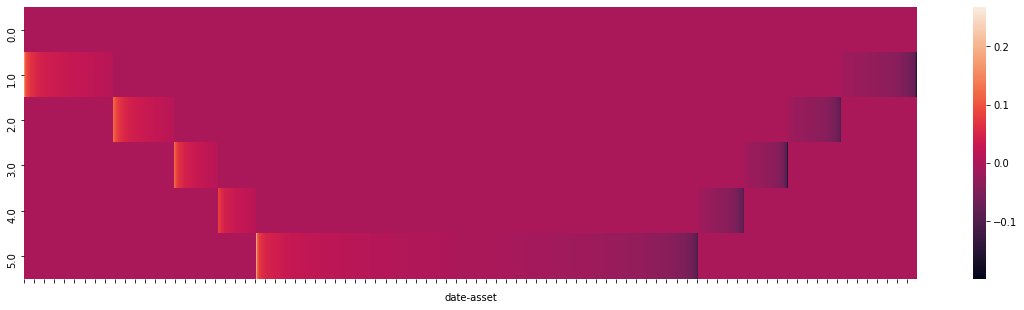

In [736]:
fig = plt.figure(figsize=(20, 5))
data = target[target['event'] == 1]
g = sns.heatmap(data[[0, 1, 2, 3, 4, 5]].sort_values([0, 1, 2, 3, 4, 5], ascending = False).T)
g.set_xticklabels(' ')
# g = sns.heatmap(target[target['label'] == -1] [[0, 1, 3, 4, 5]], cmap = 'viridis', ax = axes[1])

In [549]:
class testStrategy2(bt.Strategy):
    
    params = (
        ('long', 26),
        ('short', 12),
        ('macd_roll', 9),
        ('vol_p', 200),
        ('min_trail_vol', 2500000 * 16.5) #
    )
    
    def log(self, txt, dt = None):
        # logging function from the strategy
        dt = dt or self.data.datetime.date(0)
        print(f"{dt.isoformat()}, {txt}")
        
    def __init__(self):
        
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.symbol = None
        self.factor = None
        self.current_position = None
        self.s_pos = 0
        self.s_neg = 0
        
        self.dailyVolatility = {}
        self.prices = {}
        self.date = {}
        for symbol in self.getdatanames():
            self.dataclose = self.getdatabyname(symbol).close
            
            self.prices[symbol] = self.dataclose 
            
            self.date[symbol] = self.data.datetime
        
        self.devfactor = 2
        self.factor = {}
        for symbol in self.getdatanames():
            self.dataclose = self.getdatabyname(symbol).close

            self.midband = bt.indicators.SimpleMovingAverage(self.dataclose, period = 20)
            self.topband = self.midband + self.devfactor * bt.indicators.StdDev(self.dataclose, period = 20)
            self.botband = self.midband - self.devfactor * bt.indicators.StdDev(self.dataclose, period = 20)
            
            self.factor[symbol] = (self.dataclose - self.botband) / ((self.topband - self.botband) + 0.00001) * -1

        self.trailing_volume = {}
        for symbol in self.getdatanames():
            self.dataclose = self.getdatabyname(symbol).close
            self.datavolume = self.getdatabyname(symbol).volume
            self.d_volume = self.dataclose * self.datavolume
            self.vol = bt.indicators.SMA(self.d_volume, period = self.p.vol_p)
            
            self.trailing_volume[symbol] = self.vol
            
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # do nothing
            pass
    
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f"BUY EXECUTED ({self.symbol}): {order.executed.price}, {order.executed.value}, {order.executed.comm}")
            elif order.issell():
                self.log(f"SELL EXECUTED ({self.symbol}): {order.executed.price}")
            self.bar_executed = len(self)
        elif order.status in [order.Cancelled, order.Margin, order.Rejected]:
            self.log(f"({self.symbol}) Order Cancelled, Margin, Rejected")
            
        # Write down: no pending order
        self.order = None
        
    def prenext(self):
        self.next()
        

    def next(self):
        
        if len(self) >= 200: # and (len(self) % 10) == 0 
        
            factor_values = {}
            volume = {}
            volatility = {}
            log_returns = {}
            eventTracker = {}
            dates = {}
            for symbol in self.getdatanames():

                data_length = len(self.factor[symbol])
                if data_length != 0:

                    date = self.date[symbol].date(0)
                    dates[symbol] = date

                    factor_value = self.factor[symbol][0]
                    factor_values[symbol] = factor_value

                    trail_vol = self.trailing_volume[symbol][0]
                    volume[symbol] = trail_vol

                    # -------------------------------------
                    raw_prices = self.prices[symbol].get(size = 150)
                    
                    date_index = pd.Series(np.array(self.date[symbol].get(size = 150)))
                    date_index = [bt.utils.date.num2date(date) for date in date_index]
                    
                    if len(raw_prices) == len(date_index):
                    
                        prices = pd.Series(np.array(raw_prices), index = date_index)
                    
                        daily_vol = ml.util.get_daily_vol(
                                        prices, 
                                        lookback = 20)
                        threshold = daily_vol.iloc[-1]
                    
                        volatility[symbol] = threshold
                    
                        # log returns
                        raw_time_series = pd.DataFrame(prices)  # Convert to DataFrame
                        raw_time_series.columns = ['price']
                        log_ret = raw_time_series.price.apply(np.log).diff().iloc[-1]
                        log_returns[symbol] = log_ret
                        # -------------------------------------

                        pos = float(self.s_pos + log_ret)
                        neg = float(self.s_neg + log_ret)
                        self.s_pos = max(0.0, pos)
                        self.s_neg = min(0.0, neg)

                        if self.s_neg < -threshold:
                            self.s_neg = 0
                            event = True

                        elif self.s_pos > threshold:
                            self.s_pos = 0
                            event = True

                        else:
                            event = False

                        eventTracker[symbol] = event
                
            out = pd.concat([
                        pd.DataFrame.from_dict(
                            dates, orient = 'index', columns = ['date']),
                        pd.DataFrame.from_dict(
                            factor_values, orient = 'index', columns = ['factor']),
                        pd.DataFrame.from_dict(
                            volume, orient = 'index', columns = ['volume']),
                        pd.DataFrame.from_dict(
                            volatility, orient = 'index', columns = ['threshold']),
                        pd.DataFrame.from_dict(
                            log_returns, orient = 'index', columns = ['log_returns']),
                        pd.DataFrame.from_dict(
                            eventTracker, orient = 'index', columns = ['event'])
                
                        ],axis = 1)
            
            # volume filter
            out = out[out['volume'] >= self.p.min_trail_vol]
            
            # event based filter
            out = out[out['event'] == True]
            
            self.log(f"OUT")
            print(f"{out}")
            
            if len(out) > 3:
                positions = pd.qcut(out['factor'], q = 3, labels = [-1, 0, 1]) #, duplicates = 'drop'

                factor_values = pd.DataFrame.from_dict(factor_values, orient = 'index', columns = ['factor'])
                factor_values['side'] = positions
                factor_values.dropna(inplace = True)

                factor_values = factor_values[factor_values['side'].isin([1, -1])]

                factor_total = factor_values['factor'].sub(factor_values['factor'].mean()).abs().sum()
                demeaned_factor_values = factor_values['factor'].sub(factor_values['factor'].mean()).to_dict()

                factor_weights = {}
                for asset, value in demeaned_factor_values.items():
                    factor_weights[asset] = value / factor_total

                for asset in positions.dropna().index:
                    if asset not in factor_weights.keys():
                        factor_weights[asset] = 0.0        

                positions = dict(positions.dropna())
                self.log(f"{positions}")
                self.log(f"{pd.DataFrame.from_dict(factor_weights, orient = 'index', columns = ['weight'])}\n")


#                 for symbol, position in positions.items():
#                     self.symbol = symbol
#                     self.current_position = self.getpositionbyname(self.symbol).size
#                     self.log(f"----{self.symbol}----------------------------------------------------------------------------------")
#                     self.log(f"- CURRENT POSITION - {self.current_position}")
#                     self.log(f"- Recom: {position}")

#                     portfolio_value = self.broker.getvalue()
#                     cash = self.broker.getcash()
#                     self.log(f"Current Portfolio value: {portfolio_value} Cash {cash}\n")

#                     if self.current_position > 0:

#                         # BUY/
#                         if positions[self.symbol] == 1:
#                             order_percent = factor_weights[self.symbol]
#                             self.log(f"REBALANCE POSITION: Order_percent - {order_percent} Portfolio value - {order_percent * portfolio_value} \n")
#                             self.order = self.order_target_percent(self.getdatabyname(self.symbol), order_percent)
#                         # SHORT/
#                         elif positions[self.symbol] == -1:
#                             order_percent = factor_weights[self.symbol]
#                             # first close the long position
#                             self.order = self.close(data = self.getdatabyname(self.symbol))
#                             self.log(f"CLOSE Long Position \n")
#                             # then enter the short position
#                             self.log(f"SELL-short CREATE: Order_percent - {order_percent} Portfolio value - {order_percent * portfolio_value} \n")
#                             self.order = self.order_target_percent(self.getdatabyname(self.symbol), order_percent)
#                         # DO NOTHING
#                         elif positions[self.symbol] == 0:

#                             # close just the long position
#                             self.order = self.close(data = self.getdatabyname(self.symbol))
#                             self.log(f"CLOSE Long Position \n")

#                     elif self.current_position < 0:

#                         # BUY/
#                         if positions[self.symbol] == 1:
#                             order_percent = factor_weights[self.symbol]

#                             # first close the short position
#                             self.order = self.close(data = self.getdatabyname(self.symbol))
#                             self.log(f"CLOSE Short Position \n")
#                             # then enter the long position
#                             self.order = self.order_target_percent(self.getdatabyname(self.symbol), order_percent)
#                             self.log(f"SELL-short CREATE: Order_percent - {order_percent} Portfolio value - {order_percent * portfolio_value} \n")

#                         elif positions[self.symbol] == -1:
#                             order_percent = factor_weights[self.symbol]
#                             self.log(f"REBALANCE POSITION: Order_percent - {order_percent} Portfolio value - {order_percent * portfolio_value} \n")
#                             self.order = self.order_target_percent(self.getdatabyname(self.symbol), order_percent)

#                         elif positions[self.symbol] == 0:

#                             # close just the short position
#                             self.order = self.close(data = self.getdatabyname(self.symbol))
#                             self.log(f"CLOSE Short Position \n")


#                     elif self.current_position == 0:

#                         # BUY/
#                         if positions[self.symbol] == 1:
#                             order_percent = factor_weights[self.symbol]
#                             self.log(f"BUY-long CREATE: Order_percent - {order_percent} Portfolio value - {order_percent * portfolio_value} \n")
#                             self.order = self.order_target_percent(self.getdatabyname(self.symbol), order_percent)

#                         # SHORT/
#                         elif positions[self.symbol] == -1:
#                             order_percent = factor_weights[self.symbol]
#                             self.log(f"SELL-short CREATE: Order_percent - {order_percent} Portfolio value - {order_percent * portfolio_value} \n")
#                             self.order = self.order_target_percent(self.getdatabyname(self.symbol), order_percent)

#                         # DO NOTHING
#                         elif positions[self.symbol] == 0:
#                             self.log(f"DO NOTHING \n")

#                     self.symbol = None
#                 print(' ')


In [550]:
cerebro2 = bt.Cerebro() #stdstats=False

cerebro2.addstrategy(testStrategy2)

0

In [551]:
# symbols = list(prices.keys())
# symbols
# symbols.remove('WHL.JO')

In [552]:
class PandasData(bt.feed.DataBase):
    params = (
        ('datetime', None),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('openinterest', None),
    )

start = datetime(2016, 1, 1)
end = datetime(2017, 12, 31)

for s in symbols: #['WHL.JO'] + 
        data = train_prices[s]
        if len(data) > 200:

#             data['open'] = data['close'].shift(1)

            data = bt.feeds.PandasData(dataname = data, fromdate = start, todate = end)
            cerebro2.adddata(data, name = s)    # Give the data to cerebro

In [553]:
# Set our desired cash start
cerebro2.broker.setcash(1000000.0)
# 0.1% ... divide by 100 to remove the %
# cerebro.broker.setcommission(commission = 0.001)

# # add analyzer
cerebro2.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')


# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro2.broker.getvalue())

# Run over everything
strat = cerebro2.run(runonce = False, maxcpus = 4)

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro2.broker.getvalue())

Starting Portfolio Value: 1000000.00
2016-10-06, OUT
              date    factor        volume  threshold  log_returns  event
LBH.JO  2016-10-06 -0.454659  8.020966e+09   0.014160    -0.007925   True
INP.JO  2016-10-06 -0.553134  2.189407e+10   0.019056     0.001396   True
CML.JO  2016-10-06 -0.849786  6.732356e+09   0.028577     0.015890   True
SHP.JO  2016-10-06 -0.458165  3.386696e+10   0.024717    -0.028836   True
HCI.JO  2016-10-06 -0.725302  7.358463e+08   0.011816     0.000000   True
2016-10-06, {'LBH.JO': 1, 'INP.JO': 0, 'CML.JO': -1, 'SHP.JO': 1, 'HCI.JO': -1}
2016-10-06,           weight
LBH.JO  0.252647
CML.JO -0.343984
SHP.JO  0.247353
HCI.JO -0.156016
INP.JO  0.000000

2016-10-07, OUT
              date    factor        volume  threshold  log_returns  event
LBH.JO  2016-10-07 -0.344640  8.033998e+09   0.014229    -0.005463   True
INP.JO  2016-10-07 -0.426765  2.196338e+10   0.018877    -0.014642   True
SHP.JO  2016-10-07 -0.616414  3.399430e+10   0.023962     0.015831   T

2016-10-27, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2016-10-27 -0.538281  3.390497e+09   0.017913     0.000831   True
IPF.JO    2016-10-27 -0.841949  6.116654e+08   0.019748     0.023182   True
NGPLD.JO  2016-10-27 -0.119264  1.082991e+09   0.018052    -0.022502   True
2016-10-28, OUT
              date    factor        volume  threshold  log_returns  event
LBH.JO  2016-10-28 -0.503250  7.990848e+09   0.014074    -0.011137   True
PPC.JO  2016-10-28 -0.217645  2.992060e+09   0.041720    -0.037805   True
PAN.JO  2016-10-28 -0.183275  8.480353e+08   0.029905    -0.033902   True
CML.JO  2016-10-28 -0.369570  7.063729e+09   0.020866    -0.041255   True
VKE.JO  2016-10-28 -0.539538  1.496912e+09   0.012381    -0.007596   True
REM.JO  2016-10-28 -0.323431  3.108125e+10   0.016590    -0.011612   True
2016-10-28, {'LBH.JO': -1, 'PPC.JO': 1, 'PAN.JO': 1, 'CML.JO': 0, 'VKE.JO': -1, 'REM.JO': 0}
2016-10-28,           weight
LBH.JO -0.221733
PPC.JO 

2016-11-09, OUT
                date    factor        volume  threshold  log_returns  event
NTC.JO    2016-11-09 -0.497948  1.885218e+10   0.017114    -0.005732   True
INP.JO    2016-11-09 -0.767864  2.141478e+10   0.014740     0.010707   True
PAN.JO    2016-11-09 -0.516999  8.733252e+08   0.038052     0.069796   True
IPL.JO    2016-11-09 -0.445214  1.476529e+10   0.019621    -0.012048   True
AGL.JO    2016-11-09 -1.122326  6.368479e+10   0.029619     0.049368   True
VKE.JO    2016-11-09 -0.733619  1.542316e+09   0.012217     0.018519   True
NGPLD.JO  2016-11-09 -0.887902  1.081045e+09   0.028258     0.031609   True
2016-11-09, {'NTC.JO': 1, 'INP.JO': -1, 'PAN.JO': 0, 'IPL.JO': 1, 'AGL.JO': -1, 'VKE.JO': 0, 'NGPLD.JO': -1}
2016-11-09,             weight
NTC.JO    0.225825
INP.JO   -0.021650
IPL.JO    0.274175
AGL.JO   -0.346642
NGPLD.JO -0.131708
PAN.JO    0.000000
VKE.JO    0.000000

2016-11-10, OUT
                date    factor        volume  threshold  log_returns  event
SCP.JO    

2016-11-25, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2016-11-25  0.049364  3.014573e+09   0.015738    -0.011166   True
PPC.JO    2016-11-25 -0.029599  3.011957e+09   0.033387    -0.035402   True
LEW.JO    2016-11-25 -0.539041  1.080335e+09   0.053729     0.111730   True
HCI.JO    2016-11-25 -0.326615  8.011305e+08   0.012768    -0.004776   True
2016-11-25, {'NGPLT.JO': 1, 'PPC.JO': 0, 'LEW.JO': -1, 'HCI.JO': -1}
2016-11-25,             weight
NGPLT.JO  0.500000
LEW.JO   -0.415203
HCI.JO   -0.084797
PPC.JO    0.000000

2016-11-28, OUT
                date    factor        volume  threshold  log_returns  event
SCP.JO    2016-11-28 -0.959485  2.006995e+08   0.026769     0.038221   True
NGPLT.JO  2016-11-28  0.160883  2.975280e+09   0.015551    -0.019826   True
INP.JO    2016-11-28 -0.694628  2.048821e+10   0.015574    -0.021591   True
VKE.JO    2016-11-28 -0.457840  1.499936e+09   0.015619     0.009447   True
IPF.JO    2016-11-28 -0.174651 

2016-12-13, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2016-12-13 -0.246725  2.859732e+09   0.011482     0.006316   True
PPC.JO    2016-12-13 -0.469645  3.009794e+09   0.028251     0.014312   True
SHP.JO    2016-12-13 -0.803507  3.453558e+10   0.021150     0.014629   True
VKE.JO    2016-12-13 -0.393441  1.529413e+09   0.016020    -0.041957   True
IPF.JO    2016-12-13 -0.370986  5.969426e+08   0.021344    -0.031952   True
REM.JO    2016-12-13 -1.111847  3.127183e+10   0.026046     0.038432   True
2016-12-13, {'NGPLT.JO': 1, 'PPC.JO': 0, 'SHP.JO': -1, 'VKE.JO': 0, 'IPF.JO': 1, 'REM.JO': -1}
2016-12-13,             weight
NGPLT.JO  0.297880
SHP.JO   -0.131192
IPF.JO    0.202120
REM.JO   -0.368808
PPC.JO    0.000000
VKE.JO    0.000000

2016-12-14, OUT
                date    factor        volume  threshold  log_returns  event
SCP.JO    2016-12-14  0.109335  1.730674e+08   0.029558    -0.068993   True
NGPLT.JO  2016-12-14 -0.474046  2.864812e+0

2017-01-03, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2017-01-03 -0.554948  2.204502e+09   0.019651     0.033499   True
PPC.JO    2017-01-03 -1.041149  2.919903e+09   0.021359     0.039012   True
CML.JO    2017-01-03 -0.760258  6.771933e+09   0.023695    -0.006976   True
IPL.JO    2017-01-03 -0.789699  1.419594e+10   0.021516     0.015177   True
IPF.JO    2017-01-03  0.047747  5.730658e+08   0.017216    -0.028817   True
HCI.JO    2017-01-03 -0.810199  7.731772e+08   0.015857     0.000000   True
NGPLD.JO  2017-01-03 -0.536688  1.314657e+09   0.059416     0.064266   True
2017-01-03, {'NGPLT.JO': 0, 'PPC.JO': -1, 'CML.JO': 0, 'IPL.JO': -1, 'IPF.JO': 1, 'HCI.JO': -1, 'NGPLD.JO': 1}
2017-01-03,             weight
PPC.JO   -0.272032
IPL.JO   -0.107267
IPF.JO    0.441479
HCI.JO   -0.120700
NGPLD.JO  0.058521
NGPLT.JO  0.000000
CML.JO    0.000000

2017-01-04, OUT
              date    factor        volume  threshold  log_returns  event
LBH.JO  20

2017-01-24, OUT
              date    factor        volume  threshold  log_returns  event
SCP.JO  2017-01-24 -0.161416  1.450758e+08   0.021066     0.007273   True
PPC.JO  2017-01-24 -1.307500  2.885340e+09   0.040529     0.079205   True
VKE.JO  2017-01-24 -0.660044  1.474140e+09   0.013672     0.005277   True
REM.JO  2017-01-24 -0.686750  2.971395e+10   0.016853     0.015175   True
2017-01-24, {'SCP.JO': 1, 'PPC.JO': -1, 'VKE.JO': 0, 'REM.JO': -1}
2017-01-24,           weight
SCP.JO  0.472998
PPC.JO -0.500000
REM.JO  0.027002
VKE.JO  0.000000

2017-01-25, OUT
                date    factor        volume  threshold  log_returns  event
SCP.JO    2017-01-25 -0.033696  1.429403e+08   0.020218    -0.021979   True
LBH.JO    2017-01-25 -0.880064  6.501561e+09   0.015694     0.018266   True
NTC.JO    2017-01-25 -0.247993  1.838807e+10   0.014125    -0.027909   True
INP.JO    2017-01-25 -0.980505  1.989118e+10   0.012918     0.017947   True
CML.JO    2017-01-25 -0.564445  6.446364e+09   0.0173

2017-02-09, OUT
              date    factor        volume  threshold  log_returns  event
SCP.JO  2017-02-09  0.009450  1.128908e+08   0.016923    -0.024693   True
NTC.JO  2017-02-09 -0.526608  1.822173e+10   0.013283     0.023833   True
INP.JO  2017-02-09 -0.553744  1.969326e+10   0.011426     0.003044   True
CML.JO  2017-02-09  0.076611  6.523421e+09   0.016572    -0.014341   True
AGL.JO  2017-02-09 -0.091554  5.787895e+10   0.030595    -0.029649   True
VKE.JO  2017-02-09 -0.168566  1.485973e+09   0.010345     0.010805   True
IPF.JO  2017-02-09 -0.567255  5.819375e+08   0.010144     0.012176   True
REM.JO  2017-02-09 -0.342645  2.949367e+10   0.013560     0.007520   True
2017-02-09, {'SCP.JO': 1, 'NTC.JO': -1, 'INP.JO': -1, 'CML.JO': 1, 'AGL.JO': 1, 'VKE.JO': 0, 'IPF.JO': -1, 'REM.JO': 0}
2017-02-09,           weight
SCP.JO  0.173537
NTC.JO -0.152907
INP.JO -0.169432
CML.JO  0.214436
AGL.JO  0.112028
IPF.JO -0.177660
VKE.JO  0.000000
REM.JO  0.000000

2017-02-10, OUT
                

2017-02-27, OUT
                date    factor        volume  threshold  log_returns  event
SCP.JO    2017-02-27 -0.327352  1.151766e+08   0.045193    -0.046884   True
NGPLT.JO  2017-02-27 -0.660300  1.891344e+09   0.013323     0.015386   True
INP.JO    2017-02-27  0.120671  1.935488e+10   0.011522    -0.012435   True
CML.JO    2017-02-27 -0.785585  6.505067e+09   0.016118    -0.006168   True
VKE.JO    2017-02-27 -0.324354  1.538613e+09   0.012914    -0.004258   True
IPF.JO    2017-02-27 -0.511398  5.906476e+08   0.019698    -0.000629   True
HCI.JO    2017-02-27 -0.991454  7.419592e+08   0.014407     0.023589   True
2017-02-27, {'SCP.JO': 0, 'NGPLT.JO': -1, 'INP.JO': 1, 'CML.JO': -1, 'VKE.JO': 1, 'IPF.JO': 0, 'HCI.JO': -1}
2017-02-27,             weight
NGPLT.JO -0.077455
INP.JO    0.380471
CML.JO   -0.150916
VKE.JO    0.119529
HCI.JO   -0.271629
SCP.JO    0.000000
IPF.JO    0.000000

2017-02-28, OUT
              date    factor        volume  threshold  log_returns  event
LBH.JO  2017

2017-03-15, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2017-03-15 -0.064068  1.714505e+09   0.014562    -0.015765   True
PPC.JO    2017-03-15 -0.041481  2.963536e+09   0.029335    -0.043583   True
VKE.JO    2017-03-15 -0.620724  1.482088e+09   0.009020    -0.002599   True
LEW.JO    2017-03-15 -0.489675  9.150449e+08   0.031709    -0.031074   True
REM.JO    2017-03-15 -0.308490  2.878873e+10   0.010412     0.011485   True
NGPLD.JO  2017-03-15  0.065549  1.083567e+09   0.015120    -0.016824   True
2017-03-15, {'NGPLT.JO': 0, 'PPC.JO': 1, 'VKE.JO': -1, 'LEW.JO': -1, 'REM.JO': 0, 'NGPLD.JO': 1}
2017-03-15,             weight
PPC.JO    0.202828
VKE.JO   -0.307758
LEW.JO   -0.192242
NGPLD.JO  0.297172
NGPLT.JO  0.000000
REM.JO    0.000000

2017-03-16, OUT
              date    factor        volume  threshold  log_returns  event
LBH.JO  2017-03-16 -0.890028  6.493587e+09   0.017187     0.025262   True
PPC.JO  2017-03-16 -0.403009  2.990363e+09   

2017-04-03, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2017-04-03 -1.107870  1.502513e+09   0.017779     0.019154   True
PPC.JO    2017-04-03 -0.538511  2.905848e+09   0.026617     0.043583   True
VKE.JO    2017-04-03 -0.247042  1.456077e+09   0.013834    -0.009395   True
HCI.JO    2017-04-03 -0.406616  8.963055e+08   0.010252     0.008074   True
2017-04-03, {'NGPLT.JO': -1, 'PPC.JO': -1, 'VKE.JO': 1, 'HCI.JO': 0}
2017-04-03,             weight
NGPLT.JO -0.500000
PPC.JO    0.097152
VKE.JO    0.402848
HCI.JO    0.000000

2017-04-04, OUT
              date    factor        volume  threshold  log_returns  event
CML.JO  2017-04-04  0.038826  6.642512e+09   0.012690    -0.007038   True
VKE.JO  2017-04-04 -0.223615  1.483444e+09   0.013357     0.000524   True
HCI.JO  2017-04-04 -0.406616  8.990319e+08   0.009979     0.000000   True
2017-04-05, OUT
                date    factor        volume  threshold  log_returns  event
SCP.JO    2017-04-05  0

2017-04-21, OUT
              date    factor        volume  threshold  log_returns  event
PPC.JO  2017-04-21 -0.343035  2.852010e+09   0.022444     0.010646   True
CML.JO  2017-04-21 -0.169389  6.902815e+09   0.025515    -0.041277   True
VKE.JO  2017-04-21 -0.447784  1.476050e+09   0.017600    -0.009519   True
LEW.JO  2017-04-21  0.015199  9.089992e+08   0.019551    -0.020069   True
IPF.JO  2017-04-21 -0.298948  6.024273e+08   0.011773    -0.017790   True
HCI.JO  2017-04-21  0.157278  9.053004e+08   0.015837    -0.018167   True
2017-04-21, {'PPC.JO': -1, 'CML.JO': 0, 'VKE.JO': -1, 'LEW.JO': 1, 'IPF.JO': 0, 'HCI.JO': 1}
2017-04-21,           weight
PPC.JO -0.195630
VKE.JO -0.304370
LEW.JO  0.176254
HCI.JO  0.323746
CML.JO  0.000000
IPF.JO  0.000000

2017-04-24, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2017-04-24 -0.281968  1.379280e+09   0.016800    -0.025438   True
NTC.JO    2017-04-24 -0.428609  1.865691e+10   0.036129     0.032076   Tr

2017-05-15, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2017-05-15 -0.337473  1.682273e+09   0.016892     0.004706   True
INP.JO    2017-05-15 -0.734096  1.425613e+10   0.015253    -0.002279   True
IPL.JO    2017-05-15 -0.305652  1.345292e+10   0.024260    -0.008473   True
LEW.JO    2017-05-15 -0.051467  8.583227e+08   0.016410    -0.021011   True
2017-05-15, {'NGPLT.JO': -1, 'INP.JO': -1, 'IPL.JO': 0, 'LEW.JO': 1}
2017-05-15,             weight
NGPLT.JO  0.051247
INP.JO   -0.500000
LEW.JO    0.448753
IPL.JO    0.000000

2017-05-16, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2017-05-16 -0.329444  1.688429e+09   0.016157    -0.002722   True
NTC.JO    2017-05-16 -0.697420  1.840098e+10   0.021261     0.016770   True
PAN.JO    2017-05-16 -1.136279  7.359886e+08   0.018327     0.021899   True
CML.JO    2017-05-16 -0.873111  7.158274e+09   0.016573     0.032122   True
VKE.JO    2017-05-16 -0.800607 

2017-05-31, OUT
              date    factor        volume  threshold  log_returns  event
SCP.JO  2017-05-31 -0.305296  1.145321e+08   0.034199     0.074108   True
PAN.JO  2017-05-31 -0.682285  7.229032e+08   0.028138     0.040822   True
SHP.JO  2017-05-31 -0.801549  4.309556e+10   0.016684    -0.014959   True
AGL.JO  2017-05-31 -0.206660  5.961730e+10   0.026259    -0.014778   True
LEW.JO  2017-05-31 -0.362157  8.849309e+08   0.021445     0.024745   True
HCI.JO  2017-05-31 -0.462369  9.196907e+08   0.011353    -0.000674   True
2017-05-31, {'SCP.JO': 1, 'PAN.JO': -1, 'SHP.JO': -1, 'AGL.JO': 1, 'LEW.JO': 0, 'HCI.JO': 0}
2017-05-31,           weight
SCP.JO  0.199255
PAN.JO -0.188643
SHP.JO -0.311357
AGL.JO  0.300745
LEW.JO  0.000000
HCI.JO  0.000000

2017-06-01, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2017-06-01  0.112656  1.747587e+09   0.012948    -0.027809   True
NTC.JO    2017-06-01 -0.066157  1.806717e+10   0.017305    -0.024025   Tr

2017-06-16, OUT
Empty DataFrame
Columns: [date, factor, volume, threshold, log_returns, event]
Index: []
2017-06-19, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2017-06-19 -0.149989  1.932146e+09   0.012083     0.004777   True
INP.JO    2017-06-19 -0.392402  1.340153e+10   0.016449     0.026008   True
PAN.JO    2017-06-19  0.041478  7.151517e+08   0.022296    -0.028058   True
SHP.JO    2017-06-19 -0.518222  4.235507e+10   0.020762     0.029045   True
VKE.JO    2017-06-19 -0.442006  1.638996e+09   0.010202    -0.008797   True
LEW.JO    2017-06-19 -0.358671  8.696195e+08   0.021645    -0.022838   True
2017-06-19, {'NGPLT.JO': 1, 'INP.JO': 0, 'PAN.JO': 1, 'SHP.JO': -1, 'VKE.JO': -1, 'LEW.JO': 0}
2017-06-19,             weight
NGPLT.JO  0.137599
PAN.JO    0.362401
SHP.JO   -0.294743
VKE.JO   -0.205257
INP.JO    0.000000
LEW.JO    0.000000

2017-06-20, OUT
                date    factor        volume  threshold  log_returns  event
SCP.JO    2017

2017-07-04, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2017-07-04 -0.657036  1.932715e+09   0.011143     0.013347   True
CML.JO    2017-07-04 -0.465478  7.509017e+09   0.024118     0.003788   True
LEW.JO    2017-07-04 -0.218148  8.536947e+08   0.023732    -0.021333   True
2017-07-05, OUT
              date    factor        volume  threshold  log_returns  event
SCP.JO  2017-07-05 -1.029993  1.153138e+08   0.027895     0.035091   True
LBH.JO  2017-07-05 -0.523723  6.489728e+09   0.010821     0.007839   True
NTC.JO  2017-07-05 -0.378116  1.706800e+10   0.014453    -0.020644   True
PAN.JO  2017-07-05 -0.408199  6.980742e+08   0.042126     0.081415   True
IPL.JO  2017-07-05 -0.663732  1.285082e+10   0.020101    -0.025169   True
LEW.JO  2017-07-05 -0.419658  8.507888e+08   0.022600     0.017963   True
2017-07-05, {'SCP.JO': -1, 'LBH.JO': 0, 'NTC.JO': 1, 'PAN.JO': 1, 'IPL.JO': -1, 'LEW.JO': 0}
2017-07-05,           weight
SCP.JO -0.451817
NTC.JO 

2017-07-20, OUT
                date    factor        volume  threshold  log_returns  event
NTC.JO    2017-07-20 -0.403175  1.586002e+10   0.017926     0.017629   True
INP.JO    2017-07-20 -0.760978  1.236401e+10   0.011695     0.001301   True
SHP.JO    2017-07-20 -0.786883  4.024325e+10   0.015673    -0.020623   True
IPL.JO    2017-07-20 -1.256732  1.288437e+10   0.026855     0.031591   True
AGL.JO    2017-07-20 -0.650369  5.816336e+10   0.024396    -0.026174   True
LEW.JO    2017-07-20  0.042554  8.674689e+08   0.020522    -0.011263   True
REM.JO    2017-07-20 -0.570679  2.798355e+10   0.009912    -0.003731   True
NGPLD.JO  2017-07-20 -0.156786  1.161676e+09   0.016660    -0.018714   True
2017-07-20, {'NTC.JO': 1, 'INP.JO': -1, 'SHP.JO': -1, 'IPL.JO': -1, 'AGL.JO': 0, 'LEW.JO': 1, 'REM.JO': 0, 'NGPLD.JO': 1}
2017-07-20,             weight
NTC.JO    0.065798
INP.JO   -0.090640
SHP.JO   -0.101966
IPL.JO   -0.307393
LEW.JO    0.260679
NGPLD.JO  0.173524
AGL.JO    0.000000
REM.JO    0.00

2017-08-07, OUT
              date    factor        volume  threshold  log_returns  event
LBH.JO  2017-08-07  0.016406  6.733190e+09   0.020801     0.014118   True
PPC.JO  2017-08-07 -0.026705  1.892252e+09   0.037972    -0.033152   True
PAN.JO  2017-08-07  0.155571  6.527728e+08   0.023324    -0.039051   True
SHP.JO  2017-08-07 -0.314469  4.033205e+10   0.020677    -0.043613   True
VKE.JO  2017-08-07 -0.911298  1.850210e+09   0.011883    -0.005089   True
REM.JO  2017-08-07 -1.145226  2.725027e+10   0.010860     0.013747   True
2017-08-07, {'LBH.JO': 1, 'PPC.JO': 0, 'PAN.JO': 1, 'SHP.JO': 0, 'VKE.JO': -1, 'REM.JO': -1}
2017-08-07,           weight
LBH.JO  0.218776
PAN.JO  0.281224
VKE.JO -0.197515
REM.JO -0.302485
PPC.JO  0.000000
SHP.JO  0.000000

2017-08-08, OUT
              date    factor        volume  threshold  log_returns  event
LBH.JO  2017-08-08  0.072560  6.807961e+09   0.019788    -0.018773   True
NTC.JO  2017-08-08 -0.571308  1.574012e+10   0.016631     0.036664   True
INP

2017-08-23, OUT
              date    factor        volume  threshold  log_returns  event
NTC.JO  2017-08-23 -0.519428  1.547365e+10   0.014210    -0.008797   True
INP.JO  2017-08-23 -0.689164  1.231380e+10   0.010680    -0.004187   True
VKE.JO  2017-08-23  0.095048  1.824711e+09   0.011430    -0.007435   True
IPF.JO  2017-08-23  0.091977  8.000608e+08   0.011729    -0.009788   True
HCI.JO  2017-08-23 -0.919020  8.655280e+08   0.012324     0.010630   True
2017-08-23, {'NTC.JO': 0, 'INP.JO': -1, 'VKE.JO': 1, 'IPF.JO': 1, 'HCI.JO': -1}
2017-08-23,           weight
INP.JO -0.185981
VKE.JO  0.250855
IPF.JO  0.249145
HCI.JO -0.314019
NTC.JO  0.000000

2017-08-24, OUT
              date    factor        volume  threshold  log_returns  event
NTC.JO  2017-08-24 -0.530854  1.541849e+10   0.013674     0.001605   True
INP.JO  2017-08-24 -0.995386  1.229198e+10   0.010206     0.009941   True
IPL.JO  2017-08-24 -1.223390  1.320985e+10   0.033768     0.064914   True
VKE.JO  2017-08-24 -0.023939  1.8

2017-09-08, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2017-09-08 -0.954052  2.296433e+09   0.012704     0.009376   True
LBH.JO    2017-09-08 -0.773186  7.048114e+09   0.019493     0.015217   True
INP.JO    2017-09-08 -0.185534  1.220822e+10   0.009937    -0.002036   True
IPL.JO    2017-09-08 -0.428337  1.385532e+10   0.027365    -0.023280   True
AGL.JO    2017-09-08 -0.720182  5.391622e+10   0.017325    -0.020203   True
VKE.JO    2017-09-08 -0.535536  1.880960e+09   0.008311     0.010554   True
LEW.JO    2017-09-08 -0.655953  7.991006e+08   0.036273     0.045640   True
REM.JO    2017-09-08 -0.194117  2.582052e+10   0.011308     0.004283   True
NGPLD.JO  2017-09-08 -0.382125  1.408689e+09   0.020433     0.003847   True
2017-09-08, {'NGPLT.JO': -1, 'LBH.JO': -1, 'INP.JO': 1, 'IPL.JO': 0, 'AGL.JO': -1, 'VKE.JO': 0, 'LEW.JO': 0, 'REM.JO': 1, 'NGPLD.JO': 1}
2017-09-08,             weight
NGPLT.JO -0.248680
LBH.JO   -0.141382
INP.JO    0.207240

2017-09-26, OUT
              date    factor        volume  threshold  log_returns  event
SCP.JO  2017-09-26 -0.967926  9.302891e+07   0.026047     0.041964   True
NTC.JO  2017-09-26 -0.134189  1.423992e+10   0.016019    -0.016422   True
INP.JO  2017-09-26  0.011915  1.221524e+10   0.012726    -0.018936   True
CML.JO  2017-09-26  0.040963  5.889061e+09   0.012653    -0.019231   True
IPL.JO  2017-09-26 -0.317111  1.425158e+10   0.020711    -0.018501   True
AGL.JO  2017-09-26 -0.181413  5.330328e+10   0.019332    -0.025241   True
IPF.JO  2017-09-26 -0.961241  8.568772e+08   0.011012    -0.001254   True
REM.JO  2017-09-26  0.038713  2.582815e+10   0.010717    -0.016543   True
2017-09-26, {'SCP.JO': -1, 'NTC.JO': 0, 'INP.JO': 1, 'CML.JO': 1, 'IPL.JO': -1, 'AGL.JO': 0, 'IPF.JO': -1, 'REM.JO': 1}
2017-09-26,           weight
SCP.JO -0.251380
INP.JO  0.153199
CML.JO  0.165193
IPL.JO  0.017344
IPF.JO -0.248620
REM.JO  0.164264
NTC.JO  0.000000
AGL.JO  0.000000

2017-09-27, OUT
                

2017-10-12, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2017-10-12 -0.743775  2.172601e+09   0.009288    -0.001608   True
LBH.JO    2017-10-12 -0.993831  7.407343e+09   0.011428     0.014581   True
INP.JO    2017-10-12 -0.462279  1.224048e+10   0.012866     0.002023   True
CML.JO    2017-10-12 -0.996750  6.071978e+09   0.012086     0.012716   True
IPL.JO    2017-10-12 -1.220454  1.454804e+10   0.018450     0.036834   True
IPF.JO    2017-10-12 -0.828441  9.478721e+08   0.015705    -0.015371   True
HCI.JO    2017-10-12 -0.439898  8.597959e+08   0.020009     0.034246   True
NGPLD.JO  2017-10-12 -1.090084  1.457926e+09   0.019753     0.029865   True
2017-10-12, {'NGPLT.JO': 1, 'LBH.JO': 0, 'INP.JO': 1, 'CML.JO': -1, 'IPL.JO': -1, 'IPF.JO': 0, 'HCI.JO': 1, 'NGPLD.JO': -1}
2017-10-12,             weight
NGPLT.JO  0.049216
INP.JO    0.218656
CML.JO   -0.103056
IPL.JO   -0.237709
HCI.JO    0.232128
NGPLD.JO -0.159235
LBH.JO    0.000000
IPF.JO    0.

2017-10-30, OUT
              date    factor        volume  threshold  log_returns  event
SCP.JO  2017-10-30 -0.803071  1.141317e+08   0.048468     0.062914   True
LBH.JO  2017-10-30 -0.578991  7.361802e+09   0.016063     0.016529   True
PPC.JO  2017-10-30 -0.916882  2.933943e+09   0.029604     0.040351   True
CML.JO  2017-10-30 -0.541692  6.088746e+09   0.016768     0.009644   True
SHP.JO  2017-10-30 -0.020671  3.981828e+10   0.013984    -0.023011   True
IPL.JO  2017-10-30 -0.766853  1.474287e+10   0.030067     0.058319   True
IPF.JO  2017-10-30 -0.258188  9.138192e+08   0.016181     0.019418   True
2017-10-30, {'SCP.JO': -1, 'LBH.JO': 0, 'PPC.JO': -1, 'CML.JO': 0, 'SHP.JO': 1, 'IPL.JO': -1, 'IPF.JO': 1}
2017-10-30,           weight
SCP.JO -0.151037
PPC.JO -0.219813
SHP.JO  0.321765
IPL.JO -0.129151
IPF.JO  0.178235
LBH.JO  0.000000
CML.JO  0.000000

2017-10-31, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2017-10-31 -0.928836  2.302958e+09

2017-11-15, OUT
              date    factor        volume  threshold  log_returns  event
LBH.JO  2017-11-15 -0.393657  7.006703e+09   0.012730    -0.015595   True
NTC.JO  2017-11-15  0.157518  1.424378e+10   0.023797    -0.069700   True
AGL.JO  2017-11-15 -0.473875  5.409887e+10   0.025396    -0.031110   True
IPF.JO  2017-11-15 -0.791417  9.070576e+08   0.014059     0.009509   True
REM.JO  2017-11-15  0.080679  2.861057e+10   0.013547    -0.020129   True
2017-11-15, {'LBH.JO': 0, 'NTC.JO': 1, 'AGL.JO': -1, 'IPF.JO': -1, 'REM.JO': 1}
2017-11-15,           weight
NTC.JO  0.275553
AGL.JO -0.144399
IPF.JO -0.355601
REM.JO  0.224447
LBH.JO  0.000000

2017-11-16, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2017-11-16 -0.645568  2.342671e+09   0.011206    -0.014906   True
LBH.JO    2017-11-16 -0.470971  7.006510e+09   0.012737     0.004080   True
INP.JO    2017-11-16  0.100908  1.234421e+10   0.011050    -0.019702   True
PAN.JO    2017-11-16 -0.7

2017-12-01, OUT
                date    factor        volume  threshold  log_returns  event
SCP.JO    2017-12-01 -0.249275  1.172002e+08   0.048068     0.049597   True
PPC.JO    2017-12-01 -1.083122  2.866145e+09   0.038600     0.055570   True
SHP.JO    2017-12-01 -1.011471  3.506627e+10   0.013423     0.022008   True
AGL.JO    2017-12-01 -0.090933  5.370554e+10   0.024326     0.004932   True
LEW.JO    2017-12-01 -0.613006  8.050980e+08   0.046291     0.082163   True
NGPLD.JO  2017-12-01 -0.325024  1.757641e+09   0.013255     0.013721   True
2017-12-01, {'SCP.JO': 1, 'PPC.JO': -1, 'SHP.JO': -1, 'AGL.JO': 1, 'LEW.JO': 0, 'NGPLD.JO': 0}
2017-12-01,             weight
SCP.JO    0.204872
PPC.JO   -0.270421
SHP.JO   -0.229579
AGL.JO    0.295128
LEW.JO    0.000000
NGPLD.JO  0.000000

2017-12-04, OUT
                date    factor        volume  threshold  log_returns  event
NGPLT.JO  2017-12-04  0.047090  2.319008e+09   0.010260    -0.014887   True
LBH.JO    2017-12-04 -0.786083  6.800303e+0

2017-12-19, OUT
              date    factor        volume  threshold  log_returns  event
SCP.JO  2017-12-19 -0.481542  1.218985e+08   0.078459     0.113329   True
LBH.JO  2017-12-19 -1.221170  6.559347e+09   0.027802     0.036002   True
NTC.JO  2017-12-19 -1.312940  1.441510e+10   0.022442     0.044644   True
PAN.JO  2017-12-19  0.050561  6.756137e+08   0.036756    -0.045557   True
SHP.JO  2017-12-19 -0.597780  3.761191e+10   0.036204     0.031650   True
IPL.JO  2017-12-19 -1.241110  1.515810e+10   0.049487     0.061834   True
IPF.JO  2017-12-19 -0.879296  8.827309e+08   0.023951     0.010050   True
REM.JO  2017-12-19 -1.217284  3.112578e+10   0.035822     0.043932   True
HCI.JO  2017-12-19 -1.357400  8.211993e+08   0.038132     0.056299   True
2017-12-19, {'SCP.JO': 1, 'LBH.JO': 0, 'NTC.JO': -1, 'PAN.JO': 1, 'SHP.JO': 1, 'IPL.JO': -1, 'IPF.JO': 0, 'REM.JO': 0, 'HCI.JO': -1}
2017-12-19,           weight
SCP.JO  0.118579
NTC.JO -0.169831
PAN.JO  0.303165
SHP.JO  0.078256
IPL.JO -0.1449

In [520]:
cerebro2.broker.get_cash()

1378168.4570770264

In [522]:
cerebro2.broker.startingcash

1000000.0

In [526]:
cerebro2.broker.getvalue()

1002678.9367446899

In [530]:
sharpe = strat[0].analyzers.getbyname('sharpe')
sharpe.get_analysis()

OrderedDict([('sharperatio', -4.246253026092007)])

In [ ]:
del cerebro2